In [112]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt

Torch version: 1.11.0


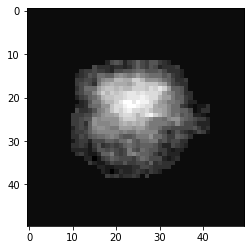

In [116]:
%matplotlib inline
img_path = 'sub_images_final/CP3wA5.epi.bmp'
# Load color image 
bgr_img = cv2.imread(img_path)
# Convert to grayscale
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
# Normalize, rescale entries to lie in [0,1]
gray_img = gray_img.astype("float32")/255
# Plot image
plt.imshow(gray_img, cmap='gray')
plt.show()

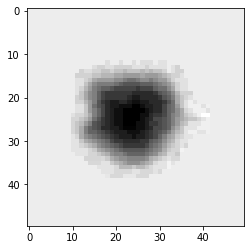

In [48]:
img_path='sub_images_final/CP3wA5.trans.bmp'
#img_path = 'sub_images_final/CP3wA5.trans.bmp'
# Load color image 
bgr_img = cv2.imread(img_path)
# Convert to grayscale
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
# Normalize, rescale entries to lie in [0,1]
gray_img = gray_img.astype("float32")/255
# Plot image
plt.imshow(gray_img, cmap='gray')
plt.show()

In [367]:
cat_to_numeric={}
with open("family.label.conversion.txt") as f:
    for line in f:
      #  print(line)
        cat_to_numeric[line.split()[0]]= line.split()[-1]

In [368]:
isolate = []
family = []
with open ("all.data") as f:
    for line in f:
        isolate.append (line.split()[0])
        family.append(line.split()[1])

In [415]:
all_data=[]
for i in range(len(isolate)):
    iso=isolate[i]
    lab= int(cat_to_numeric[family[i]])
    #trans
    img_path='sub_images_final/'+iso+'.trans.bmp'
    bgr_img = cv2.imread(img_path)
    # Convert to grayscale
    gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    gray_img = gray_img.astype("float32")/255

    gray_img_tensor_trans = torch.from_numpy(gray_img).unsqueeze(0)
    #epi
    img_path='sub_images_final/'+iso+'.epi.bmp'
    bgr_img = cv2.imread(img_path)
    gray_img_epi = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    gray_img_epi = gray_img_epi.astype("float32")/255
    gray_img_tensor_epi = torch.from_numpy(gray_img).unsqueeze(0)
    
    comb_img_tensor=(torch.cat((gray_img_tensor_trans,gray_img_tensor_epi)),lab)
    all_data.append(comb_img_tensor)

In [416]:
comb_img_tensor[0].shape

torch.Size([2, 50, 50])

In [417]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(all_data, test_size=0.2)

In [418]:
train_label=[]

for i in range(len(train_data)):
    train_label.append(train_data[i][1])
print("number of training classes are:",len(set(train_label)) )

test_label=[]
for i in range(len(test_data)):
    test_label.append(test_data[i][1])
print("number of test classes are:",len(set(test_label)) )

number of training classes are: 16
number of test classes are: 16


In [419]:
train_loader = DataLoader(train_data, batch_size=20, shuffle=True, num_workers=0)
test_loader= DataLoader(test_data,  shuffle=True, num_workers=0)
#i1, l1 = next(iter(trainloader))

In [420]:
len(train_data)

13102

In [429]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*19*19,16 )

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))   
       # print(output.shape)
        output = output.view(-1, 24*19*19)
      #  print(output.shape)
        output = self.fc1(output)
       # print(output)

        return output

# Instantiate a neural network model 
model = Network()

In [430]:
from torch.optim import Adam
 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.000001, weight_decay=0.0001)


# Training:

In [431]:
from torch.autograd import Variable

# Function to save the model
def saveModel():
    path = "./myCNNModel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
predicted_label=[]
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
          #  print(labels)
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            predicted_label.append(int(predicted[0]))
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
           # print(labels)
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            #print(labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            #print(outputs)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            #print(i)
            running_loss += loss.item()     # extract the loss value
            if i % 500 == 499:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 500))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [433]:
 train(100)

The model will be running on cpu device
[1,   500] loss: 1.933
For epoch 1 the test accuracy over the whole test set is 38 %
[2,   500] loss: 1.901
For epoch 2 the test accuracy over the whole test set is 38 %
[3,   500] loss: 1.868
For epoch 3 the test accuracy over the whole test set is 38 %
[4,   500] loss: 1.859
For epoch 4 the test accuracy over the whole test set is 38 %
[5,   500] loss: 1.858
For epoch 5 the test accuracy over the whole test set is 38 %
[6,   500] loss: 1.838
For epoch 6 the test accuracy over the whole test set is 38 %
[7,   500] loss: 1.821
For epoch 7 the test accuracy over the whole test set is 39 %
[8,   500] loss: 1.825
For epoch 8 the test accuracy over the whole test set is 38 %
[9,   500] loss: 1.821
For epoch 9 the test accuracy over the whole test set is 39 %
[10,   500] loss: 1.808
For epoch 10 the test accuracy over the whole test set is 38 %
[11,   500] loss: 1.808
For epoch 11 the test accuracy over the whole test set is 39 %
[12,   500] loss: 1.7

[95,   500] loss: 1.624
For epoch 95 the test accuracy over the whole test set is 42 %
[96,   500] loss: 1.617
For epoch 96 the test accuracy over the whole test set is 42 %
[97,   500] loss: 1.613
For epoch 97 the test accuracy over the whole test set is 42 %
[98,   500] loss: 1.614
For epoch 98 the test accuracy over the whole test set is 42 %
[99,   500] loss: 1.625
For epoch 99 the test accuracy over the whole test set is 42 %
[100,   500] loss: 1.613
For epoch 100 the test accuracy over the whole test set is 42 %


In [398]:
model = Network()
path = "myCNNModel.pth"
model.load_state_dict(torch.load(path))


In [434]:
accuracy = testAccuracy()

In [435]:
print(accuracy)

42.918192918192915


In [456]:
#go through each family, calculate TP, FP, TN, FN
results={}
for i in set(test_label):
    #print(i)
    #true positive:
    tp=0
    fp=0
    tn=0
    fn=0
    for c in range(len(predicted_label)):
        if predicted_label[c] == i:
            if test_label[c]==i:
                tp+=1
            else:
                fp+=1
        else:
            if test_label[c]!=i:
                tn+=1
            else:
                fn+=1
    prec=0
    rec=0
    if (tp+fp) >0:
        prec= tp/(tp+fp)
    if (tp+fn)>0:
        rec=tp/(tp+fn)
    results[i]=[tp, fp, tn, fn, prec,rec]

In [457]:
results

{0: [627, 1119, 1001, 529, 0.359106529209622, 0.5423875432525952],
 1: [218, 803, 1712, 543, 0.21351616062683643, 0.2864651773981603],
 2: [17, 211, 2831, 217, 0.07456140350877193, 0.07264957264957266],
 3: [2, 88, 2964, 222, 0.022222222222222223, 0.008928571428571428],
 4: [0, 3, 3094, 179, 0.0, 0.0],
 5: [2, 41, 3103, 130, 0.046511627906976744, 0.015151515151515152],
 6: [1, 10, 3169, 96, 0.09090909090909091, 0.010309278350515464],
 7: [1, 31, 3158, 86, 0.03125, 0.011494252873563218],
 8: [0, 0, 3183, 93, 0, 0.0],
 9: [0, 13, 3176, 87, 0.0, 0.0],
 10: [0, 44, 3187, 45, 0.0, 0.0],
 11: [0, 0, 3236, 40, 0, 0.0],
 12: [0, 0, 3264, 12, 0, 0.0],
 13: [0, 1, 3262, 13, 0.0, 0.0],
 14: [0, 0, 3271, 5, 0, 0.0],
 15: [2, 42, 3123, 109, 0.045454545454545456, 0.018018018018018018]}